# Clustering

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import stats

# Clustering
from sklearn import cluster, preprocessing, metrics, mixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Visualization
from sklearn import manifold

Defining a few functions which will help us with clustering

In [2]:
# getting most frequent product label for each customer
def get_first_element(s):
    """In the case s is a pd.Series containing tuples of arrays, returns the first element of the first
    array."""
    
    return s.map(lambda x: x[0][0])

# RFM

In [3]:
rfm = pd.read_csv("./data/rfm.csv")

# RFM and Products

Loading the datasets we will use in this section

In [96]:
df_clusterProducts = pd.read_csv("./data/data_categories.csv")
products_items = pd.read_csv("./data/products_items.csv")

## Products clustering

Starting by clustering products into broader categories: finding out the optimal number of clusters

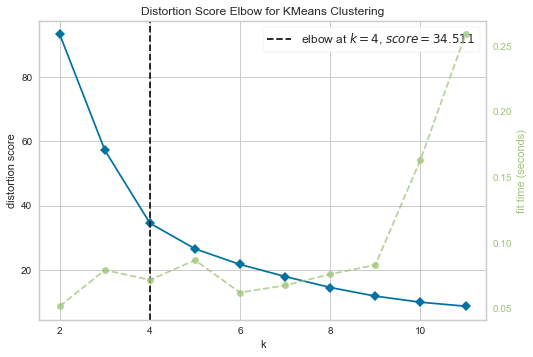

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [97]:
# comment the variables that should be taken into account for the clustering
df_clusterProducts = df_clusterProducts.drop(columns=[#"product_volume",
                    #"product_weight_g",
                    #"price",
                    "freight_to_total_price"
                   ]).dropna().set_index(["product_category_name_english"])

scaler = preprocessing.StandardScaler().fit(df_clusterProducts)
df_clusterProducts_norm = scaler.transform(df_clusterProducts)
df_clusterProducts_norm = pd.DataFrame(data=df_clusterProducts_norm, columns=df_clusterProducts.columns)


# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_clusterProducts_norm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Assessing the shape of the clusters

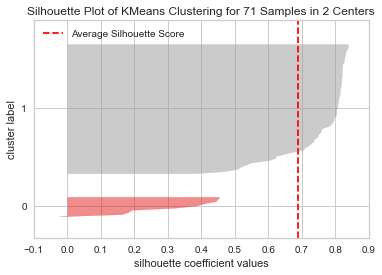

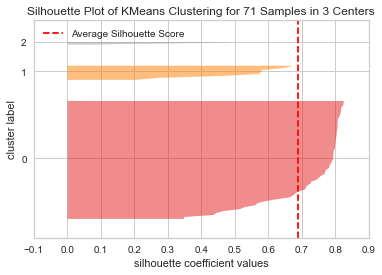

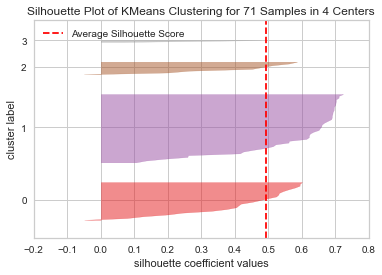

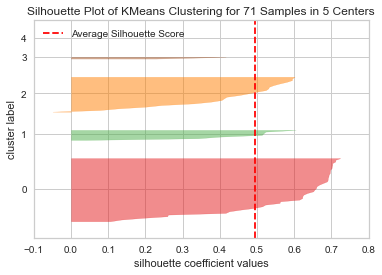

In [63]:
for n_clust in range(2, 6):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(df_clusterProducts_norm)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

Visualization of the results of clustering for the optimal number of clusters found previously, and assessment of the stability of the clusters

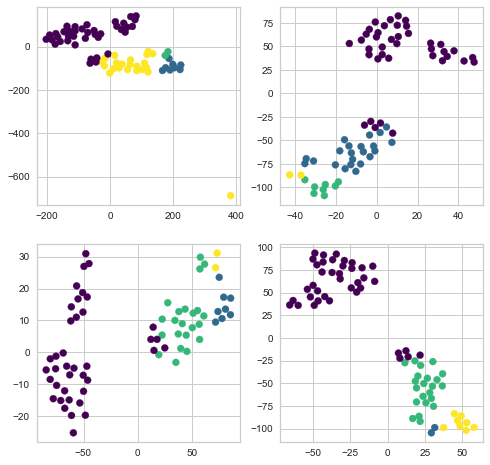

In [98]:
clustprod_std = df_clusterProducts_norm.copy()
clustprod = df_clusterProducts.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=4).fit(clustprod_std)
    
    # adding the labels obtained from clustering
    clustprod["product_label"] = clusters.labels_
    clustprod_std["product_label"] = clusters.labels_
    
    # The coordinates (standardized) for each product, and the associated category
    #categories_norm = pd.concat((clustprod_std, 
    #                         clustprod.reset_index()["product_category_name_english"]
    #                        ),
    #                        axis=1
    #                       )

    # Visualization
    X = clustprod_std.drop(columns="product_label")
    tsne = manifold.TSNE(n_components=2, perplexity=10, n_iter=5000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clustprod_std["product_label"], cmap="viridis")
plt.show()

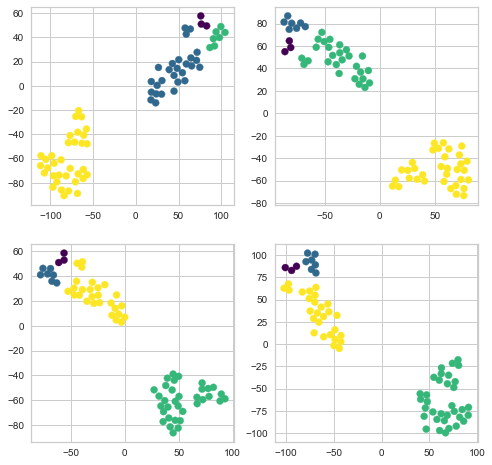

In [94]:
clustprod_std = df_clusterProducts_norm.copy()
clustprod = df_clusterProducts.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(clustprod_std)
    
    # adding the labels obtained from clustering
    clustprod["product_label"] = clusters.labels_
    clustprod_std["product_label"] = clusters.labels_
    
    # The coordinates (standardized) for each product, and the associated category
    #categories_norm = pd.concat((clustprod_std, 
    #                         clustprod.reset_index()["product_category_name_english"]
    #                        ),
    #                        axis=1
    #                       )

    # Visualization
    X = clustprod_std.drop(columns="product_label")
    tsne = manifold.TSNE(n_components=2, perplexity=10, n_iter=5000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clustprod_std["product_label"], cmap="viridis")
plt.show()

<AxesSubplot:xlabel='product_volume', ylabel='price'>

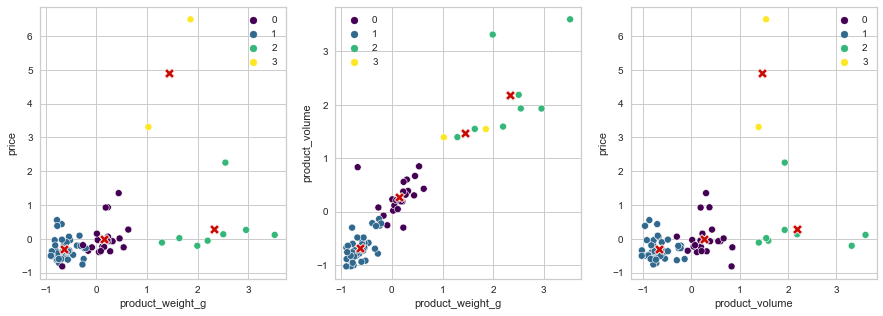

In [100]:
clustprod_std = df_clusterProducts_norm.copy()
clustprod = df_clusterProducts.copy()

clusters = cluster.KMeans(n_clusters=4).fit(clustprod_std)
centroids = pd.DataFrame(clusters.cluster_centers_, 
                         columns=["centroid_weight_g", "centroid_price", "centroid_volume"])

# adding the labels obtained from clustering
clustprod["product_label"] = clusters.labels_
clustprod_std["product_label"] = clusters.labels_
    
# The coordinates (standardized) for each product, and the associated category
categories_norm = pd.concat((clustprod_std, 
                             clustprod.reset_index()["product_category_name_english"]
                            ),
                            axis=1
                           )


# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(data=categories_norm,
                x="product_weight_g",
                y="price",
                hue="product_label",
                palette='viridis',
                ax=ax1
               )
sns.scatterplot(data=centroids,
                x="centroid_weight_g",
                y="centroid_price",
                s=100,
                color='r',
                marker='X',
                ax=ax1
               )

sns.scatterplot(data=categories_norm,
                x="product_weight_g",
                y="product_volume",
                hue="product_label",
                palette='viridis',
                ax=ax2
               )
sns.scatterplot(data=centroids,
                x="centroid_weight_g",
                y="centroid_volume",
                s=100,
                color='r',
                marker='X',
                ax=ax2
               )

sns.scatterplot(data=categories_norm,
                x="product_volume",
                y="price",
                hue="product_label",
                palette='viridis',
                ax=ax3
               )
sns.scatterplot(data=centroids,
                x="centroid_volume",
                y="centroid_price",
                s=100,
                color='r',
                marker='X',
                ax=ax3
               )

<AxesSubplot:xlabel='product_volume', ylabel='price'>

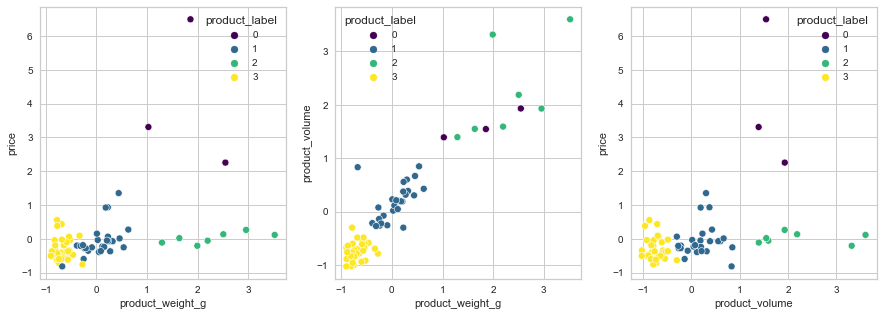

In [101]:
clustprod_std = df_clusterProducts_norm.copy()
clustprod = df_clusterProducts.copy()

clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(clustprod_std)
#centroids = pd.DataFrame(clusters.cluster_centers_, 
#                         columns=["centroid_weight_g", "centroid_price", "centroid_volume"])

# adding the labels obtained from clustering
clustprod["product_label"] = clusters.labels_
clustprod_std["product_label"] = clusters.labels_
    
# The coordinates (standardized) for each product, and the associated category
categories_norm = pd.concat((clustprod_std, 
                             clustprod.reset_index()["product_category_name_english"]
                            ),
                            axis=1
                           )


# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(data=categories_norm,
                x="product_weight_g",
                y="price",
                hue="product_label",
                palette='viridis',
                ax=ax1
               )

sns.scatterplot(data=categories_norm,
                x="product_weight_g",
                y="product_volume",
                hue="product_label",
                palette='viridis',
                ax=ax2
               )

sns.scatterplot(data=categories_norm,
                x="product_volume",
                y="price",
                hue="product_label",
                palette='viridis',
                ax=ax3
               )

In [102]:
df_clusterProducts["product_label"] = clusters.labels_

## RFM - products clustering

We merge the rfm data for each customer and the new product categories in order to perform a clustering of customers based on their rfm characteristics and the type of product they typically buy.

In [103]:
#df_products = (pd.merge(products_items, df_clusterProducts["product_label"],
#                        on="product_category_name_english",
#                        right_index=True)
#               .drop_duplicates()
#              )

rfm_product = pd.read_csv("./data/rfm_product.csv")
rfm_product = (pd.merge(rfm_product, df_clusterProducts["product_label"],
                         on="product_category_name_english",
                         right_index=True)
                .drop_duplicates()
               )
rfm_product.head()

,customer_unique_id,order_id,purchase_recency,frequency,total_order_value,product_id,product_category_name_english,product_weight_g,price,product_volume,freight_to_total_price,product_label
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,160,1,142.0,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,1500.0,129.90,7616.0,0.084567,1
13,0006fdc98a402fceb4eb0ee528f6a8d4,6681163e3dab91c549952b2845b20281,456,1,29.0,7ca5f56188492e30c50ba64de188aae7,bed_bath_table,200.0,13.90,4800.0,0.520690,1
15,00090324bbad0e9342388303bb71ba0a,85bf8863657bff31006811d45d1c8db9,207,1,64.0,f6fa93875f4a7dac03e0a22143f4d815,bed_bath_table,450.0,49.95,4275.0,0.215363,1
19,000c8bdb58a29e7115cfc257230fb21b,34801c59d6ec5c5e89bfefb6ebef314d,308,1,29.0,f07dfd51b27ae763526ca43745920b7d,bed_bath_table,175.0,13.90,1794.0,0.520690,1
21,000de6019bb59f34c099a907c151d855,c6d61340bd8baeedca7cc8e7f7ec07e9,425,1,257.0,9e572ff4654f7064419d97a891a8b0fc,bed_bath_table,1900.0,139.90,11515.0,0.110221,1


Let us now move on to clustering the customers based on RFM, and product_label

In [104]:
cluster_products_customers = rfm_product[["customer_unique_id",
                                          "purchase_recency", 
                                          "frequency", 
                                          "total_order_value",
                                          "product_label"]].copy()

# getting the most frequent product type (product label) for each customer, in order to characterize each
# customer according to the most frequently bought product type.

# first, we get rid of potential duplicates
cluster_products_customers.drop_duplicates(inplace=True)

# Then, most frequent product type for each customer
product_labels = (cluster_products_customers
                    .groupby("customer_unique_id")["product_label"]
                    .agg(stats.mode)
                    .apply(lambda x: x[0][0])
                    .reset_index()
          )

# 
cluster_products_customers = (pd.merge(cluster_products_customers.drop(columns="product_label"),
                                       product_labels,
                                       on="customer_unique_id"
                                      )
                             )

# Again, cleaning up from potential duplicates arising from the merge operation
cluster_products_customers.drop_duplicates(inplace=True)

# Finally, we one-hot encode the product_label column
clust_df = pd.concat((cluster_products_customers.drop(columns=["customer_unique_id","product_label"]), 
                      pd.get_dummies(cluster_products_customers.product_label, prefix="label")), axis=1)

Finding out the optimal number of clusters
1. silhouette score

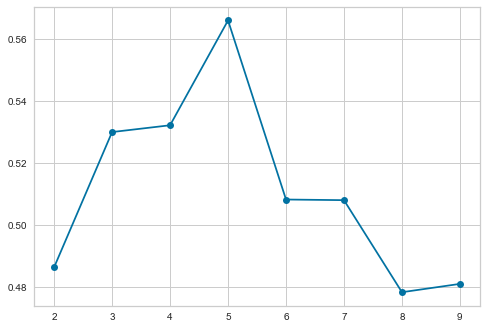

In [105]:
scaler = preprocessing.StandardScaler().fit(clust_df)
clust_df_std = pd.DataFrame(data=scaler.transform(clust_df), columns=clust_df.columns)

silhouettes = []

for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(clust_df_std)
    silh = metrics.silhouette_score(clust_df_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

2. Elbow method

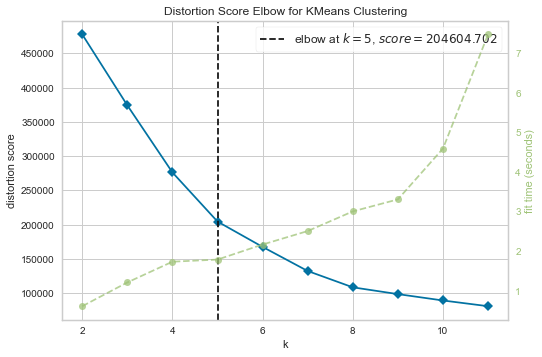

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [106]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(clust_df_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Trying another clustering algorithm - the idea is to compare the silhouette scores with the previous method

Assessing the shape of the clusters

In [ ]:
for n_clust in range(3, 6):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(clust_df_std.sample(10000))    # Fit the data to the visualizer
    visualizer.poof()

Assessing the stability of clusters

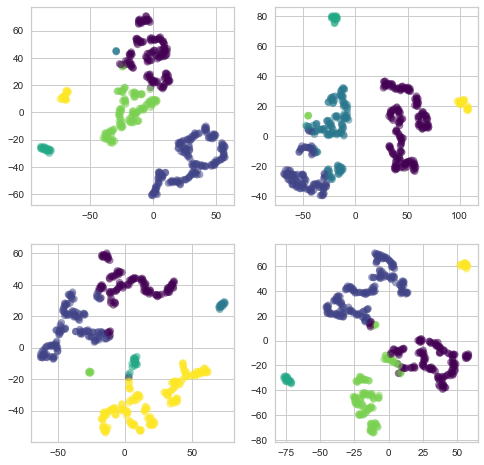

In [114]:
clust_std = clust_df_std.copy()
clust = clust_df.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=6).fit(clust_std)
    
    # adding the labels obtained from clustering
    #clust["customer_label"] = clusters.labels_
    clust_std["customer_label"] = clusters.labels_
    
    # The coordinates (standardized) for each customer, and the associated category
    #categories_norm = pd.concat((clust_std, 
    #                         clust["product_category_name_english"]
    #                        ),
    #                        axis=1
    #                       )

    # Visualization
    XX = clust_std.sample(500).copy()
    X = XX.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=10, n_iter=2000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=XX["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

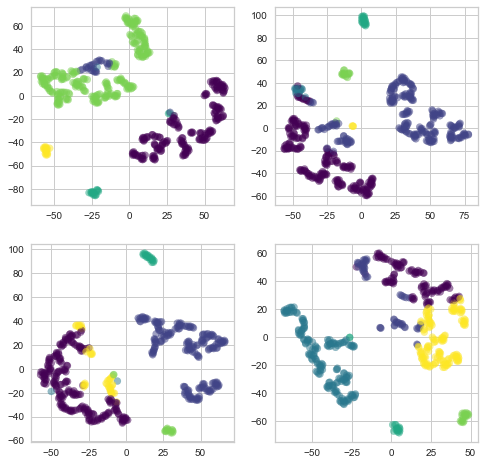

In [115]:
clust_std = clust_df_std.copy()
clust = clust_df.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = mixture.GaussianMixture(n_components=6).fit(clust_std)
    
    # adding the labels obtained from clustering
    #clust["customer_label"] = clusters.labels_
    clust_std["customer_label"] = clusters.predict(clust_std)
    
    # The coordinates (standardized) for each customer, and the associated category
    #categories_norm = pd.concat((clust_std, 
    #                         clust["product_category_name_english"]
    #                        ),
    #                        axis=1
    #                       )

    # Visualization
    XX = clust_std.sample(500).copy()
    X = XX.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=10, n_iter=2000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=XX["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

In [119]:
clusters = cluster.KMeans(n_clusters=6, n_init=10).fit(clust_df_std)
centroids = clusters.cluster_centers_

centroids = pd.DataFrame(scaler.inverse_transform(centroids).round(2), columns=clust_df.columns)
centroids

,purchase_recency,frequency,total_order_value,label_0,label_1,label_2,label_3
0,434.17,1.00,152.47,-0.0,1.00,0.0,0.00
1,174.54,1.00,162.53,-0.0,1.00,0.0,0.00
2,264.75,1.03,873.28,1.0,0.00,0.0,0.00
3,279.90,1.00,151.76,-0.0,0.00,0.0,1.00
4,268.47,2.12,311.15,0.0,0.75,0.0,0.25
5,308.55,1.02,225.79,0.0,-0.00,1.0,-0.00


434 d. = approx 1 year 3 months\
174 d. = approx 6 months\
265 d., 268 d., 280 d. = approx 9 months\
308 d. = approx 10 months

New purchase <--> new customer: 
* low monetary value purchases (type 1) = main clients. They arrive regularly, from the beginning? They seem to buy for slightly more lately.

* Some buy more than once: but other than that, they bear the same characteristics as the legacy customers. (approx 150BRL/purchase, from cat. 1 and 3. 

* Cat. 3 seems to be linked with purchases made about 270-280 days ago (9 months). Did olist added new specific items to its catalogue at that time?

* Cat 0 definitely associated to high monetary value customers. They bought only once over the past 2 and a half years, about 9 months ago (a little less).

### results for the clustering of customers based on their rfm and the main categories of products purchased

**Personae:**

|Persona#|N samples|purchase_recency|frequency|total_order_value|category 1|category 2|category 3|category 4|
|---|---|---|---|---|---|---|---|---|
|0|3467|305|1.03|249|0|1|0|0|
|1|43758|291|1|159|0|0|1|0|
|2|43490|281|1|151|1|0|0|0|
|3|250|266|1|1169|0.004|0|0|0.996|
|4|2878|268|2.1|311|0.61|0.003|0.39|0|

# RFM and Geolocation

## Geolocation clustering

We'll start by clustering the cities into broader categories based on their "average population", i.e. the average purchase value of the orders made by customers and their size. We need data from rfm analysis and customer location.

In [ ]:
# We can reuse the rfm_customers dataset
cluster_cities = (rfm_customers
     .groupby("customer_city", dropna=False)["total_order_value"]
     .agg([np.mean, np.std, np.size])
     .rename(columns={"mean":"tov_avg", 
                      "std":"tov_std"
                     })
    )

cluster_cities.head()

Finding out the optimal number of clusters
1. Silhouette score

In [ ]:
scaler = preprocessing.StandardScaler().fit(cluster_cities)
cluster_cities_std = scaler.transform(cluster_cities)
silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(cluster_cities_std)
    silh = metrics.silhouette_score(cluster_cities_std, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

2. Elbow method

In [ ]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(cluster_cities_std)    # Fit the data to the visualizer
visualizer.poof() 

Assessing the shape of clusters

In [ ]:
for n_clust in range(3, 9):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(cluster_cities_std)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

Assessing the stabilility of the clusters

In [ ]:
clusters = cluster.KMeans(n_clusters=5).fit(cluster_cities_std)
labels = clusters.labels_
cluster_cities["city_type"] = labels
cluster_cities_std = pd.DataFrame(cluster_cities_std, columns=["tov_avg", "size"])
df_std["city_type"] = labels
centers = scaler.inverse_transform(clusters.cluster_centers_)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
sns.scatterplot(data=X,
                x="tov_avg",
                y="size",
                hue="city_type",
                palette="viridis",
                alpha=1,
                linewidth=0,
                ax=ax1
               )

for ax in [ax1, ax2]:
    ax.scatter(centers[:, 0], centers[:, 1], s=50, c='red', marker="+")
    for i in range(5):
        ax.text(centers[i, 0], centers[i, 1], i, fontsize=16, color='red')

Getting representatives for each cluster

In [ ]:
# distance to centroids
X_dist = clusters.transform(X_std)

for ct in np.unique(labels):
    label_indices = np.where(labels==ct)[0]
    min_label_idx = label_indices[np.argmin(X_dist[labels==ct, ct])]
    print("Best representative of type {}: {}".format(ct, X.reset_index().iloc[min_label_idx]["customer_city"]))